In [1]:
library(data.table)
library(Matrix)
library(proxy)
library(irlba)
library(umap)
library(data.table)
library(cowplot)
library(Matrix)
library(BuenColors)
library(scales)


Attaching package: ‘proxy’

The following object is masked from ‘package:Matrix’:

    as.matrix

The following objects are masked from ‘package:stats’:

    as.dist, dist

The following object is masked from ‘package:base’:

    as.matrix

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: MASS


### Preprocess

`bsub < count_reads_peaks.sh`

In [2]:
path = './count_reads_peaks_output/'
files <- list.files(path,pattern = "\\.txt$")
length(files)

[1] 2034

In [ ]:
#assuming tab separated values with a header    
datalist = lapply(files, function(x)fread(paste0(path,x))$V4) 
#assuming the same header/columns for all files
datafr = do.call("cbind", datalist) 

In [4]:
dim(datafr)

[1] 237450   2034

In [5]:
df_regions = read.csv("../../input/combined.sorted.merged.bed",
                      sep = '\t',header=FALSE,stringsAsFactors=FALSE)

In [6]:
dim(df_regions)

[1] 237450      3

In [7]:
peaknames = paste(df_regions$V1,df_regions$V2,df_regions$V3,sep = "_")
head(peaknames)

[1] "chr1_10413_10625"   "chr1_13380_13624"   "chr1_16145_16354"  
[4] "chr1_96388_96812"   "chr1_115650_115812" "chr1_237625_237888"

In [8]:
head(sapply(strsplit(files,'\\.'),'[', 1))

[1] "BM1077-CLP-Frozen-160106-13" "BM1077-CLP-Frozen-160106-14"
[3] "BM1077-CLP-Frozen-160106-2"  "BM1077-CLP-Frozen-160106-21"
[5] "BM1077-CLP-Frozen-160106-27" "BM1077-CLP-Frozen-160106-3"

In [9]:
colnames(datafr) = sapply(strsplit(files,'\\.'),'[', 1)
rownames(datafr) = peaknames

In [10]:
dim(datafr)
head(datafr)

[1] 237450   2034

,BM1077-CLP-Frozen-160106-13,BM1077-CLP-Frozen-160106-14,BM1077-CLP-Frozen-160106-2,BM1077-CLP-Frozen-160106-21,BM1077-CLP-Frozen-160106-27,BM1077-CLP-Frozen-160106-3,BM1077-CLP-Frozen-160106-36,BM1077-CLP-Frozen-160106-42,BM1077-CLP-Frozen-160106-44,BM1077-CLP-Frozen-160106-50,⋯,singles-PB1022-mono-160128-81,singles-PB1022-mono-160128-82,singles-PB1022-mono-160128-83,singles-PB1022-mono-160128-84,singles-PB1022-mono-160128-85,singles-PB1022-mono-160128-86,singles-PB1022-mono-160128-89,singles-PB1022-mono-160128-90,singles-PB1022-mono-160128-95,singles-PB1022-mono-160128-96
chr1_10413_10625,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1_13380_13624,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1_16145_16354,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1_96388_96812,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,2,0,0
chr1_115650_115812,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1_237625_237888,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [11]:
# saveRDS(datafr, file = './datafr.rds')
# datafr = readRDS('./datafr.rds')

In [12]:
run_pca <- function(mat,num_pcs=50,scale=FALSE,center=FALSE){
    set.seed(2019) 
    mat = as.matrix(mat)
    SVD = irlba(mat, num_pcs, num_pcs,scale=scale,center=center)
    sk_diag = matrix(0, nrow=num_pcs, ncol=num_pcs)
    diag(sk_diag) = SVD$d
    SVD_vd = t(sk_diag %*% t(SVD$v))
    return(t(SVD_vd))
}

elbow_plot <- function(mat,num_pcs=50,scale=FALSE,center=FALSE,title='',width=3,height=3){
    set.seed(2019) 
    mat = data.matrix(mat)
    SVD = irlba(mat, num_pcs, num_pcs,scale=scale,center=center)
    options(repr.plot.width=width, repr.plot.height=height)
    df_plot = data.frame(PC=1:num_pcs, SD=SVD$d);
#     print(SVD$d[1:num_pcs])
    p <- ggplot(df_plot, aes(x = PC, y = SD)) +
      geom_point(col="#cd5c5c",size = 1) + 
      ggtitle(title)
    return(p)
}

run_umap <- function(fm_mat){
    umap_object = umap(t(fm_mat),random_state = 2019)
    df_umap = umap_object$layout
    return(df_umap)
}


plot_umap <- function(df_umap,labels,title='UMAP',colormap=colormap){
    set.seed(2019) 
    df_umap = data.frame(cbind(df_umap,labels),stringsAsFactors = FALSE)
    colnames(df_umap) = c('umap1','umap2','celltype')
    df_umap$umap1 = as.numeric(df_umap$umap1)
    df_umap$umap2 = as.numeric(df_umap$umap2)
    options(repr.plot.width=4, repr.plot.height=4)
    p <- ggplot(shuf(df_umap), aes(x = umap1, y = umap2, color = celltype)) +
      geom_point(size = 1) + scale_color_manual(values = colormap) +
      ggtitle(title)
    return(p)
}

run_control <- function(datafr,num_pcs=10){
    mat = as.matrix(datafr)
    fm_control = run_pca(mat,num_pcs = num_pcs)
    return(fm_control)
}

### Analysis

In [13]:
workdir = './peaks_frequency_results/'
path_umap = paste0(workdir,'umap_rds/')
path_fm = paste0(workdir,'feature_matrices/')
system(paste0('mkdir -p ',path_umap))
system(paste0('mkdir -p ',path_fm))

In [14]:
dim(datafr)

[1] 237450   2034

In [15]:
metadata <- read.table('../../input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

In [16]:
n_cells_peak = rowSums(as.matrix(datafr > 0) + 0)
df_n_cells_peak = data.frame(n_cells = n_cells_peak)

In [17]:
list_cutoff = c(1.0,0.80,0.60,0.40,0.20,0.10,0.08,0.06,0.04,0.02,0.01)

In [18]:
indices_sorted = order(n_cells_peak,decreasing = TRUE)

In [19]:
head(n_cells_peak[indices_sorted])

chr1_143913117_143913909  chr19_54693172_54695267 chr1_206137742_206138469 
                    1657                     1593                     1537 
chr3_125634492_125635760 chr1_120838178_120839004 chr3_129830069_129831514 
                    1496                     1493                     1490

In [20]:
options(repr.plot.width=3, repr.plot.height=3)
list_hist_plots = lapply(list_cutoff, function(x)
           ggplot(log10(df_n_cells_peak), aes(x=n_cells)) + labs(y='frequency')+
    geom_histogram(color="black", fill="white",bins = 50) + 
    geom_vline(aes(xintercept=log10(n_cells_peak[indices_sorted[round(length(n_cells_peak)*x)]])),
                color="indianred", linetype="dashed", size=1))
names(list_hist_plots) = as.character(list_cutoff)

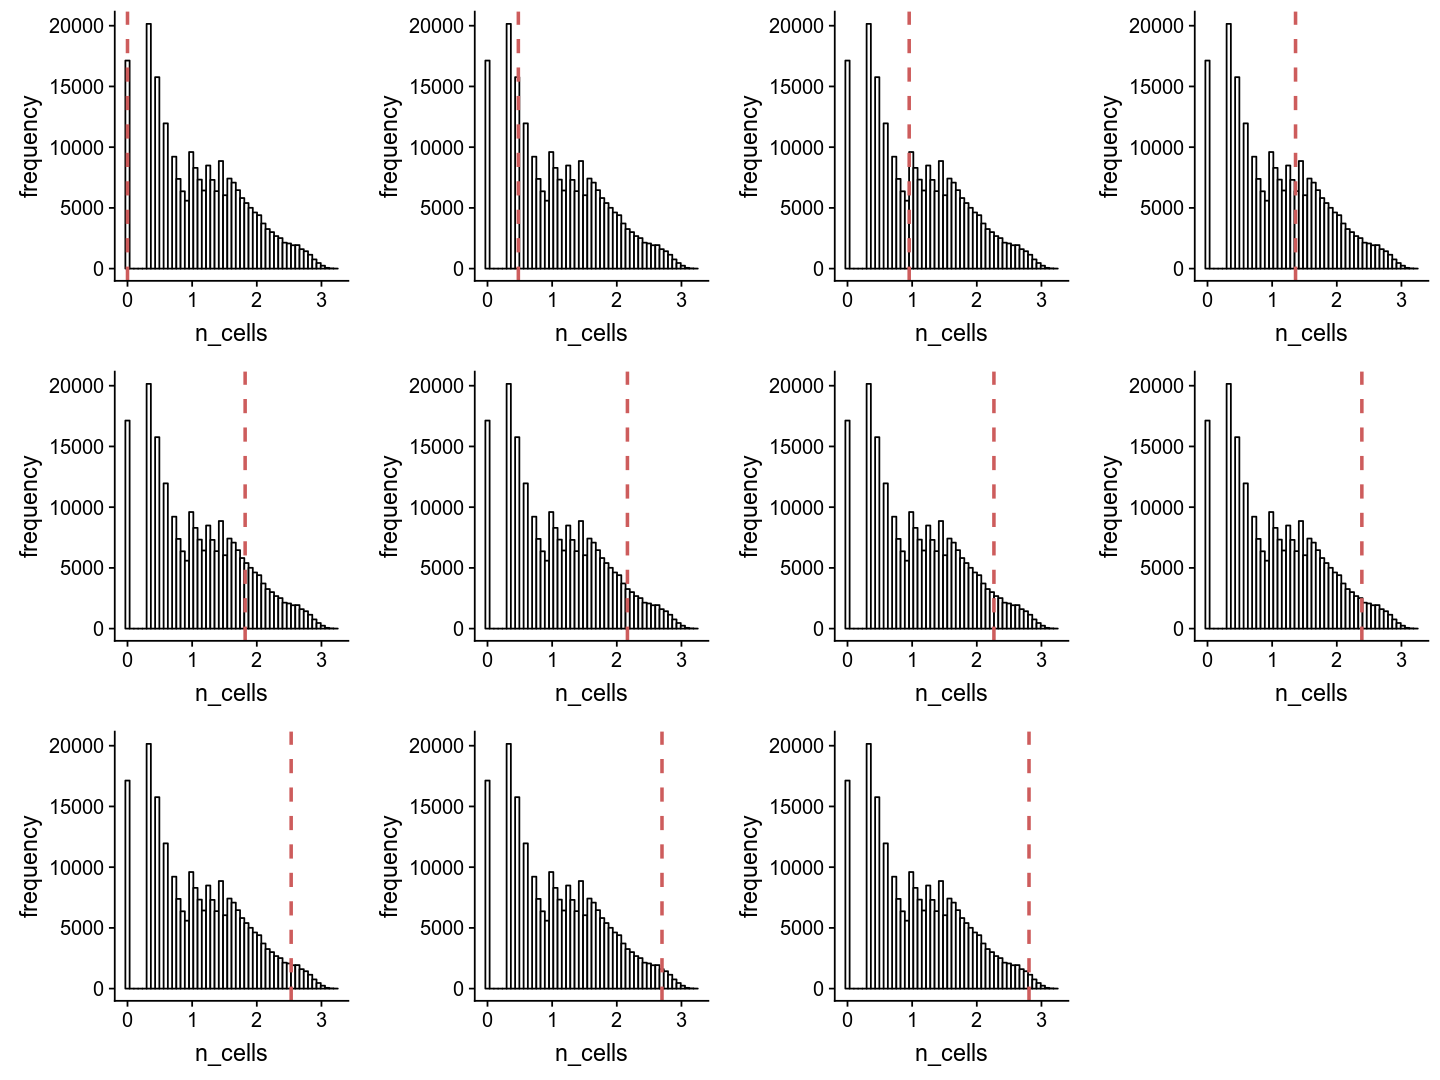

In [21]:
options(repr.plot.width=3*4, repr.plot.height=3*3)
cowplot::plot_grid(plotlist = list_hist_plots, ncol = 4)

In [22]:
colormap = c(jdb_color_maps, "UNK" = "#333333" )
labels = metadata[colnames(datafr),'label']

In [23]:
list_elbow_plots <- c()
list_umap_plots <- c()
list_n_peaks <- c()
list_fm <- c()
list_umap <- c()
for(cutoff in list_cutoff){
    datafr_sub = datafr[sort(indices_sorted[1:round(length(n_cells_peak)*cutoff)]),] 
    mat_control = datafr_sub

    list_n_peaks[[as.character(cutoff)]] <- dim(mat_control)[1]
    print(dim(mat_control))

    p_elbow_control <- elbow_plot(mat_control,num_pcs = 100, title = 'PCA on control')
    list_elbow_plots[[as.character(cutoff)]] = p_elbow_control
    
    fm_control = run_control(mat_control,num_pcs=50)
    list_fm[[as.character(cutoff)]] = fm_control
    
    df_umap_control <- run_umap(fm_control)
    list_umap[[as.character(cutoff)]] = df_umap_control
    
    p_control <- plot_umap(df_umap_control,labels = labels,colormap = colormap,
                                  title=paste0('control \n(Top ',as.character(percent(cutoff)),', ',
                                                as.character(dim(mat_control)[1]),'peaks)'))
    p_control <-  p_control+theme(legend.position = "none")
    list_umap_plots[[as.character(cutoff)]] = p_control
}

[1] 237450   2034
[1] 189960   2034
[1] 142470   2034
[1] 94980  2034
[1] 47490  2034
[1] 23745  2034
[1] 18996  2034
[1] 14247  2034
[1] 9498 2034
[1] 4749 2034
[1] 2374 2034


In [24]:
for(x in list_cutoff){
    char_cutoff = as.character(x)
    fm_mat = data.frame(list_fm[char_cutoff])
    colnames(fm_mat)=colnames(datafr)
    rownames(fm_mat)=paste0('PC',seq(dim(fm_mat)[1]))
    df_umap = data.frame(list_umap[char_cutoff])
    rownames(df_umap)=colnames(datafr)
    saveRDS(fm_mat,paste0(path_fm,'FM_control',char_cutoff,'.rds'))
    saveRDS(df_umap,paste0(path_umap, paste0('df_umap_',char_cutoff,'.rds')))
}

In [25]:
save.image(file = 'Control_peaks_frequency.RData')

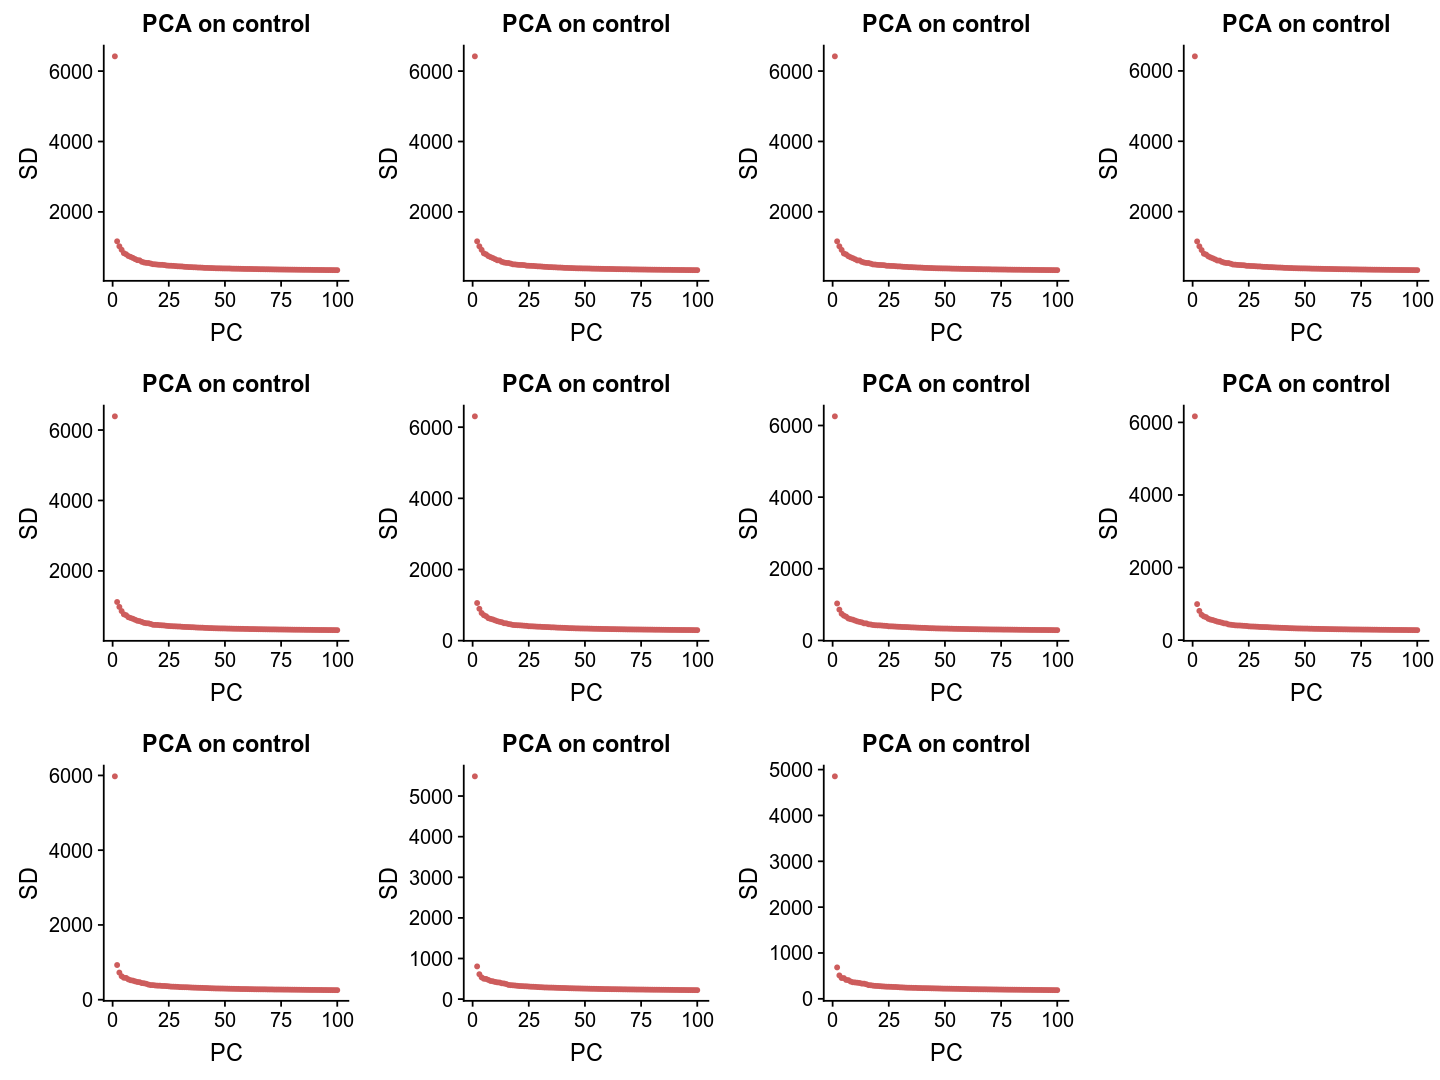

In [26]:
options(repr.plot.width=3*4, repr.plot.height=3*3)
cowplot::plot_grid(plotlist = list_elbow_plots, ncol = 4)

In [27]:
list_n_peaks

1    0.8    0.6    0.4    0.2    0.1   0.08   0.06   0.04   0.02   0.01 
237450 189960 142470  94980  47490  23745  18996  14247   9498   4749   2374

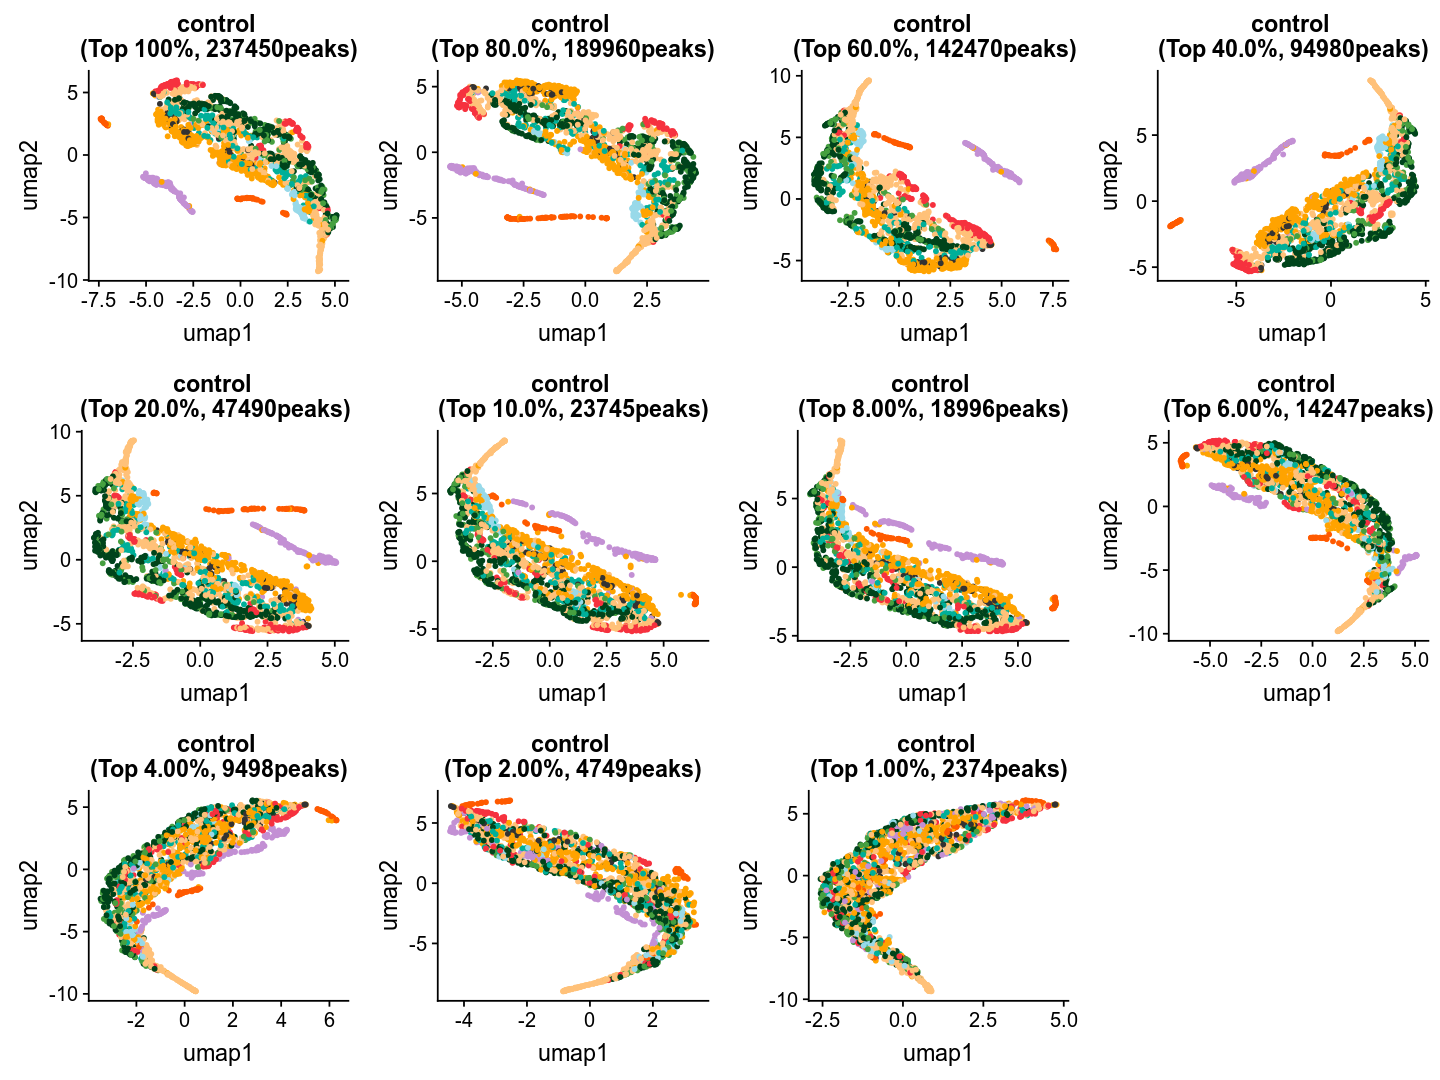

In [28]:
options(repr.plot.width=3*4, repr.plot.height=3*3)
cowplot::plot_grid(plotlist = list_umap_plots, ncol = 4)

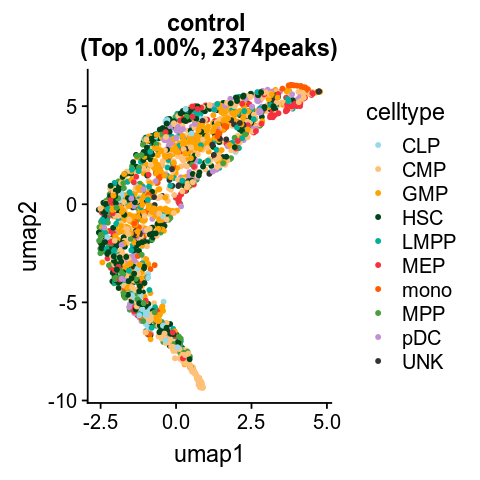

In [29]:
p_latest = plot_umap(df_umap_control,labels = labels,colormap = colormap,
                                  title=paste0('control \n(Top ',as.character(percent(cutoff)),', ',
                                                as.character(dim(mat_control)[1]),'peaks)'))
p_latest

In [30]:
library(ggpubr)

Loading required package: magrittr

Attaching package: ‘ggpubr’

The following object is masked from ‘package:cowplot’:

    get_legend



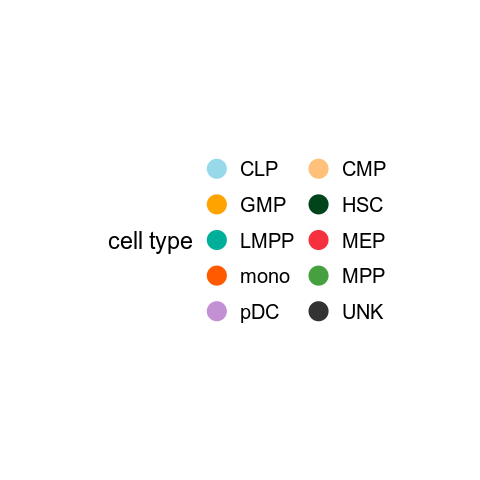

In [31]:
options(repr.plot.width=4, repr.plot.height=4)
leg <- cowplot::get_legend(p_latest + theme(legend.direction = "horizontal", legend.position = c(0.2,0.5)) + 
                           labs(color='cell type')+
                           guides(color=guide_legend(nrow=5,byrow=TRUE,override.aes = list(size=5))))

p_legend = as_ggplot(leg)
p_legend

In [32]:
list_umap_plots2 <- list_umap_plots
list_umap_plots2 <- append(list_umap_plots2, list('legend'=p_legend), 0)

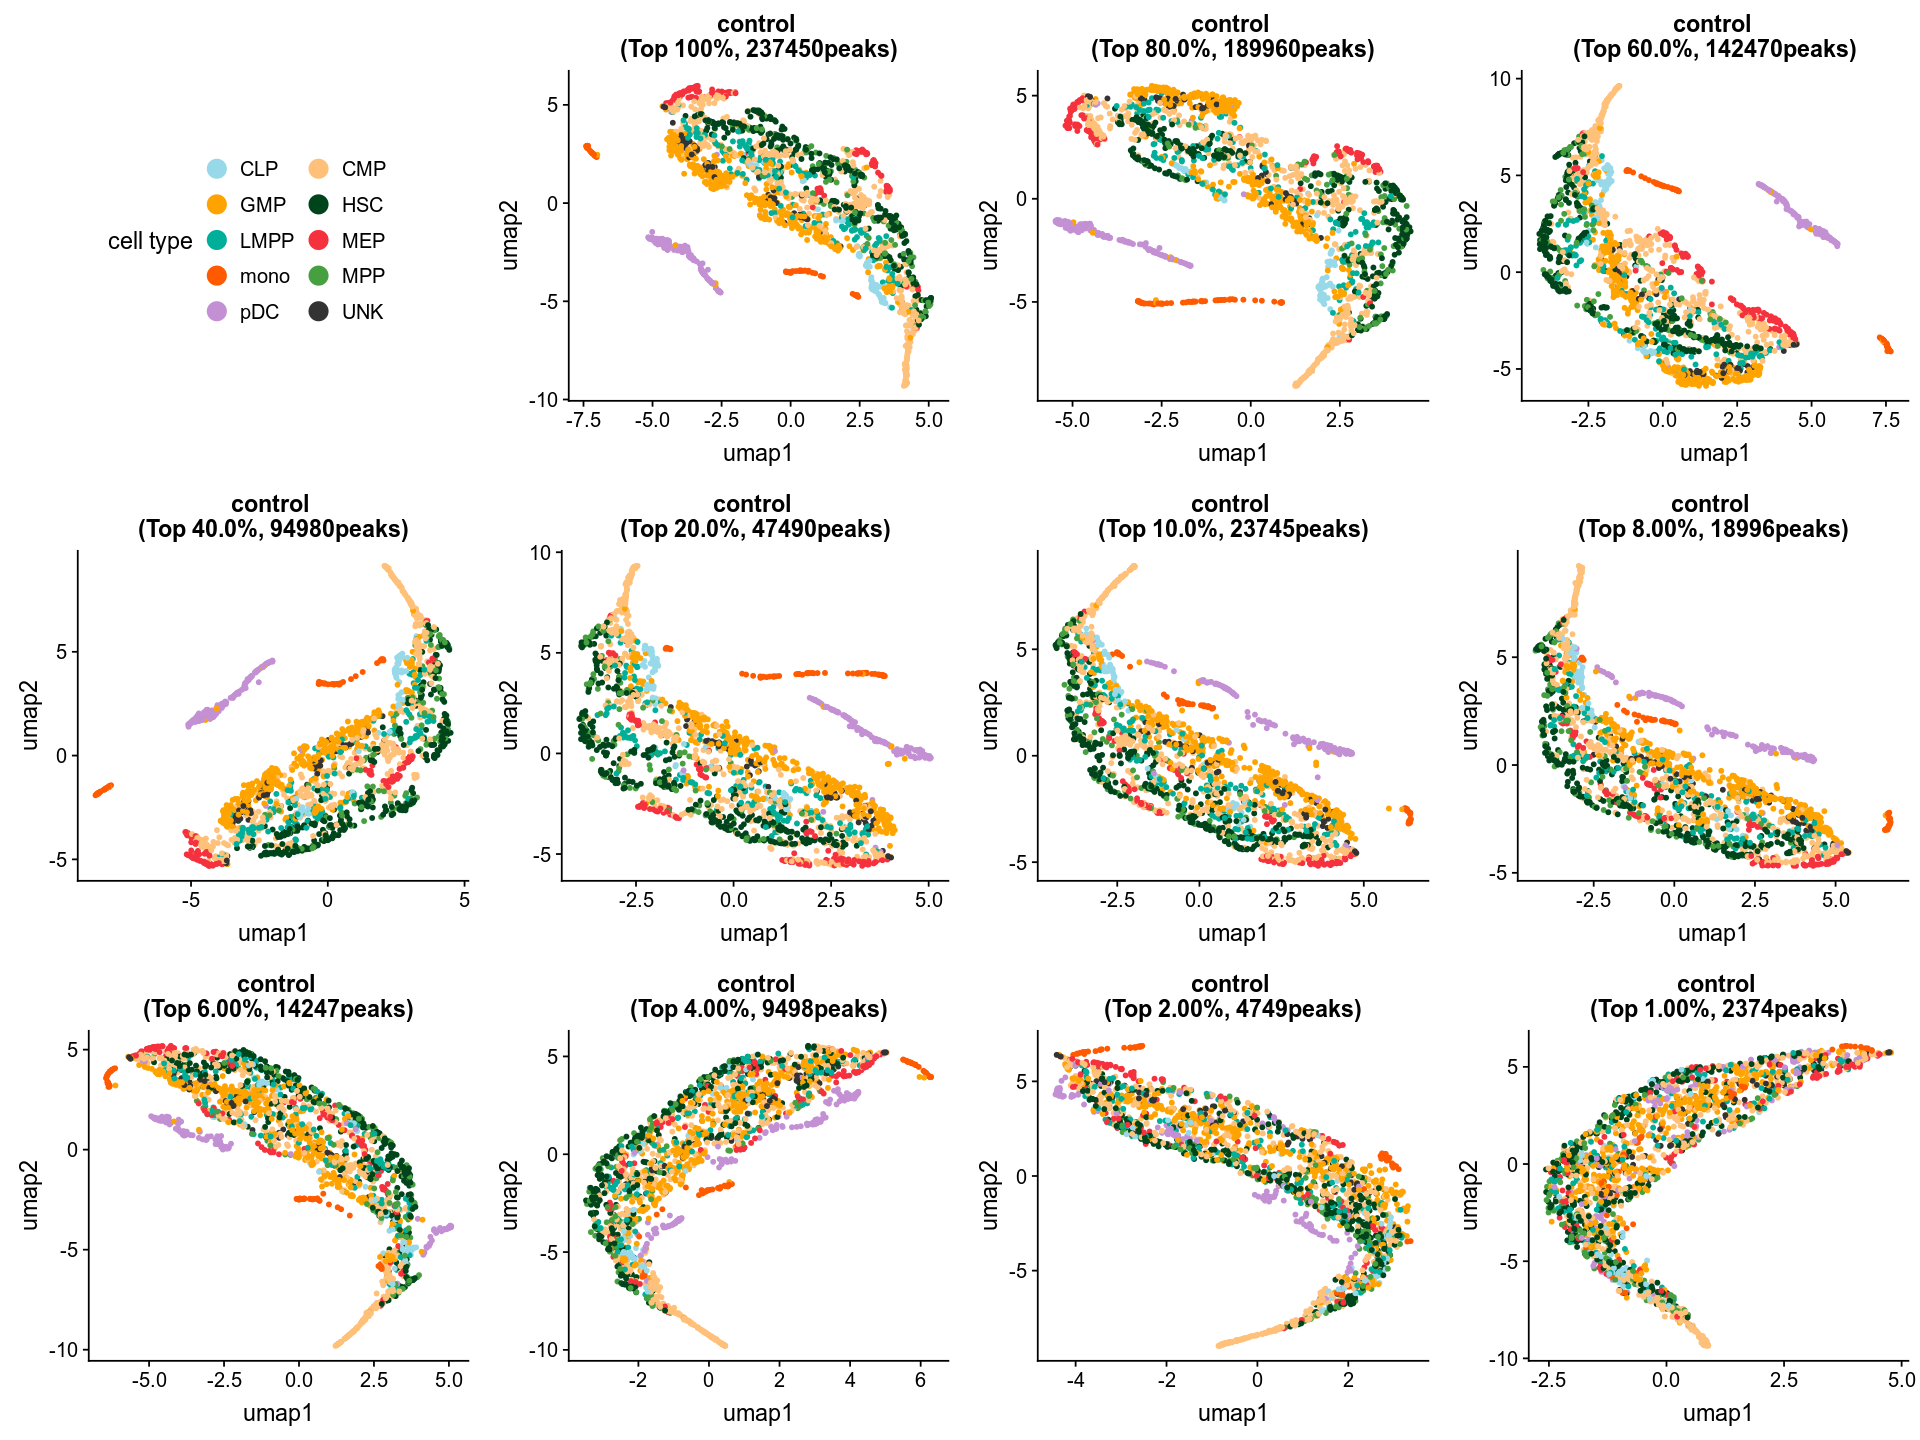

In [33]:
options(repr.plot.width=4*4, repr.plot.height=4*3)
p_group = cowplot::plot_grid(plotlist = list_umap_plots2, ncol = 4)
p_group

In [34]:
cowplot::ggsave(p_group,filename = 'Control_peaks_frequency.pdf', width = 4*4, height = 4*3)